In [1]:
import tensorflow as tf
import numpy as np
import random
import os

2025-11-21 08:04:17.826836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763712258.002776      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763712258.051779      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import time

In [4]:
bhaveshmittal_melanoma_cancer_dataset_path = '/kaggle/input/'

# Data Preprocessing

In [5]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    bhaveshmittal_melanoma_cancer_dataset_path + '/train',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    bhaveshmittal_melanoma_cancer_dataset_path + '/train',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    bhaveshmittal_melanoma_cancer_dataset_path + '/test',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 9504 images belonging to 2 classes.
Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# EDA

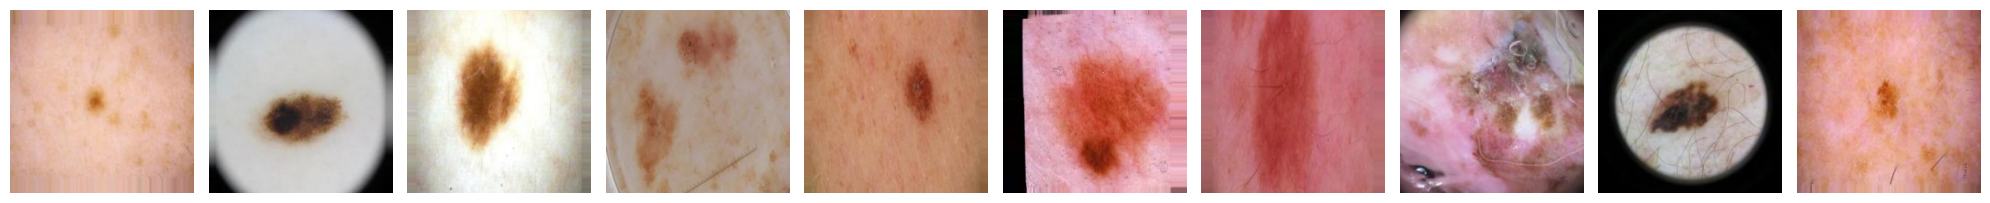

In [6]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Function to display images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 10 images from the batch
plot_images(images[:10])

In [7]:
print("Image batch shape:", images.shape)
print("Labels batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


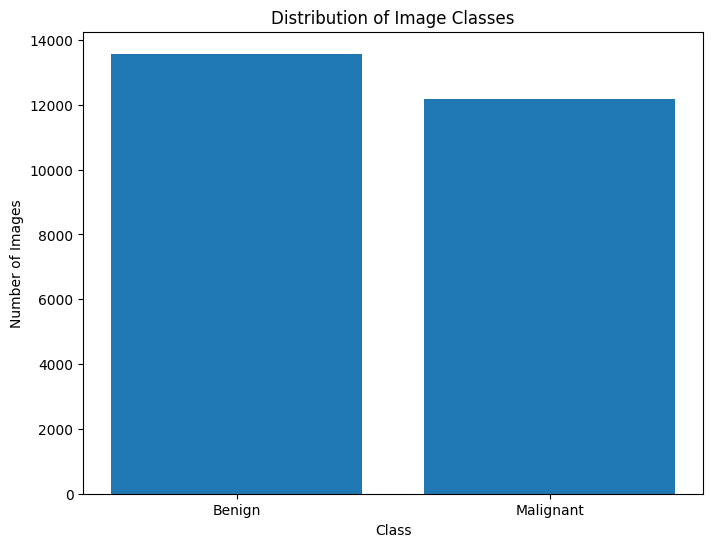

In [8]:
# Get the class indices from the training generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Count the number of images in each class in the training set
train_class_counts = {}
for class_name in class_names:
    train_class_counts[class_name] = len(os.listdir(os.path.join(bhaveshmittal_melanoma_cancer_dataset_path, 'train', class_name)))

# Count the number of images in each class in the validation set
validation_class_counts = {}
for class_name in class_names:
    validation_class_counts[class_name] = len(os.listdir(os.path.join(bhaveshmittal_melanoma_cancer_dataset_path, 'train', class_name))) # Validation set is within the training directory

# Count the number of images in each class in the test set
test_class_counts = {}
for class_name in class_names:
    test_class_counts[class_name] = len(os.listdir(os.path.join(bhaveshmittal_melanoma_cancer_dataset_path, 'test', class_name)))

# Combine counts for plotting
total_class_counts = {class_name: train_class_counts[class_name] + validation_class_counts[class_name] + test_class_counts[class_name] for class_name in class_names}

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(total_class_counts.keys(), total_class_counts.values())
plt.title('Distribution of Image Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [9]:
# Get the class names from the directory structure
class_names = os.listdir(os.path.join(bhaveshmittal_melanoma_cancer_dataset_path, 'train'))

# Initialize dictionaries to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Iterate through each class and load images
for class_name in class_names:
    class_dir = os.path.join(bhaveshmittal_melanoma_cancer_dataset_path, 'train', class_name)
    image_files = os.listdir(class_dir)
    # Load a limited number of images per class to avoid memory issues
    for image_file in image_files[:100]: # Limiting to 100 images per class for demonstration
        img_path = os.path.join(class_dir, image_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        class_images[class_name].append(img_array)

# Convert lists of images to numpy arrays
for class_name in class_names:
    class_images[class_name] = np.array(class_images[class_name])

print("Images loaded successfully for each class.")
for class_name, images in class_images.items():
    print(f"Class '{class_name}': Loaded {len(images)} images with shape {images.shape}")

Images loaded successfully for each class.
Class 'Benign': Loaded 100 images with shape (100, 224, 224, 3)
Class 'Malignant': Loaded 100 images with shape (100, 224, 224, 3)


In [10]:
pixel_stats = {}

for class_name, images in class_images.items():
    pixel_stats[class_name] = {}
    # Calculate statistics across all images and pixels for each channel
    mean_pixels = np.mean(images, axis=(0, 1, 2))
    median_pixels = np.median(images, axis=(0, 1, 2))
    std_pixels = np.std(images, axis=(0, 1, 2))
    min_pixels = np.min(images, axis=(0, 1, 2))
    max_pixels = np.max(images, axis=(0, 1, 2))

    pixel_stats[class_name]['mean'] = mean_pixels
    pixel_stats[class_name]['median'] = median_pixels
    pixel_stats[class_name]['std'] = std_pixels
    pixel_stats[class_name]['min'] = min_pixels
    pixel_stats[class_name]['max'] = max_pixels

    print(f"Statistics for class: {class_name}")
    print(f"  Mean (R, G, B): {mean_pixels}")
    print(f"  Median (R, G, B): {median_pixels}")
    print(f"  Standard Deviation (R, G, B): {std_pixels}")
    print(f"  Minimum (R, G, B): {min_pixels}")
    print(f"  Maximum (R, G, B): {max_pixels}")
    print("-" * 20)

Statistics for class: Benign
  Mean (R, G, B): [201.03378 147.94087 144.96489]
  Median (R, G, B): [205. 152. 149.]
  Standard Deviation (R, G, B): [37.432728 45.297188 49.220432]
  Minimum (R, G, B): [0. 0. 0.]
  Maximum (R, G, B): [255. 255. 255.]
--------------------
Statistics for class: Malignant
  Mean (R, G, B): [158.39821  126.778366 122.86135 ]
  Median (R, G, B): [177. 139. 135.]
  Standard Deviation (R, G, B): [65.75355 60.51386 62.93784]
  Minimum (R, G, B): [0. 0. 0.]
  Maximum (R, G, B): [255. 255. 255.]
--------------------


## Plot pixel intensity histograms


Plotting histograms for class: Benign


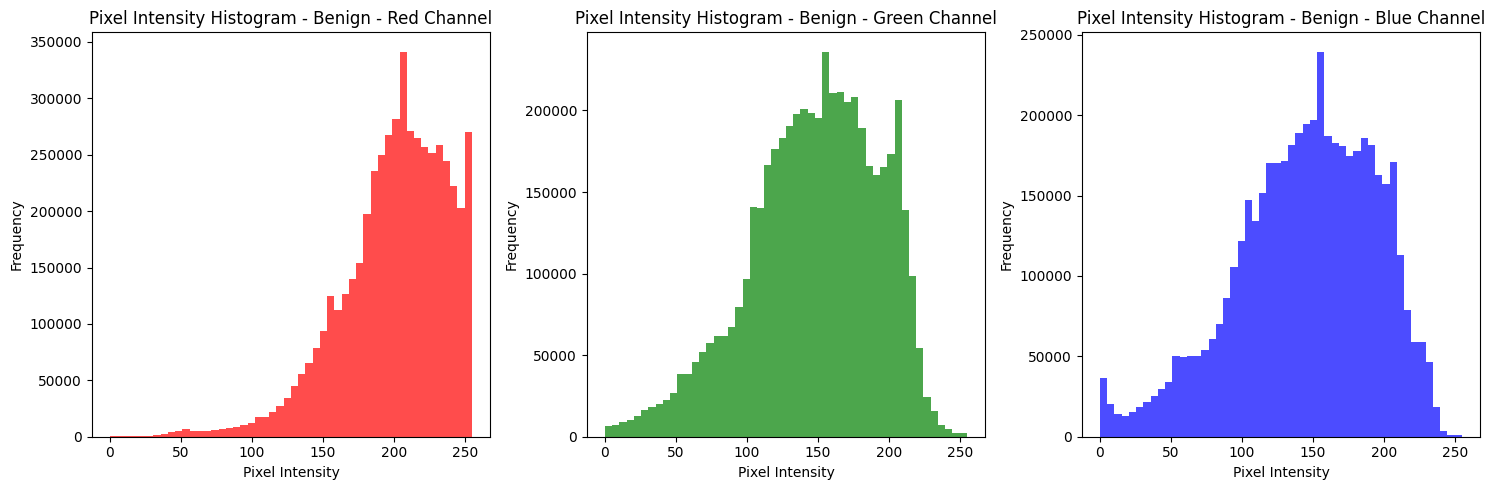

Plotting histograms for class: Malignant


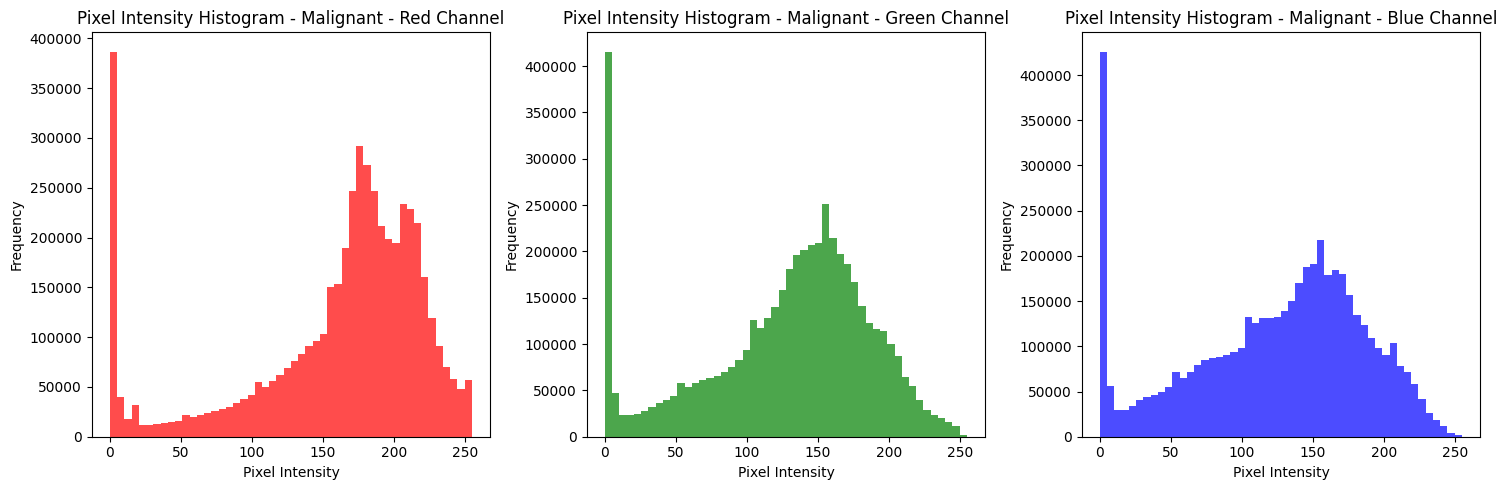

In [11]:
channel_colors = ['red', 'green', 'blue']

for class_name, images in class_images.items():
    print(f"Plotting histograms for class: {class_name}")
    plt.figure(figsize=(15, 5))
    for i in range(images.shape[-1]): # Iterate through channels (R, G, B)
        plt.subplot(1, 3, i + 1) # Create subplots for each channel
        channel_data = images[:, :, :, i].flatten() # Extract and flatten channel data
        plt.hist(channel_data, bins=50, color=channel_colors[i], alpha=0.7)
        plt.title(f"Pixel Intensity Histogram - {class_name} - {channel_colors[i].capitalize()} Channel")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

## Compute global statistics images


Mean and standard deviation images computed successfully.
Mean Image for class: Benign


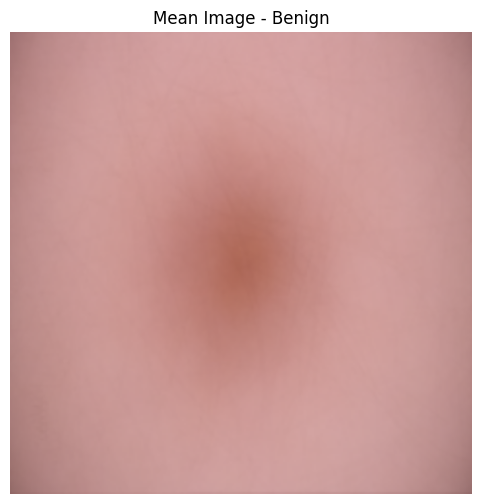

Mean Image for class: Malignant


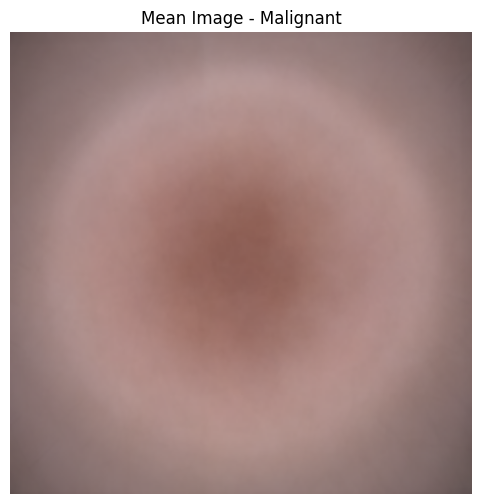

Standard Deviation Image for class: Benign


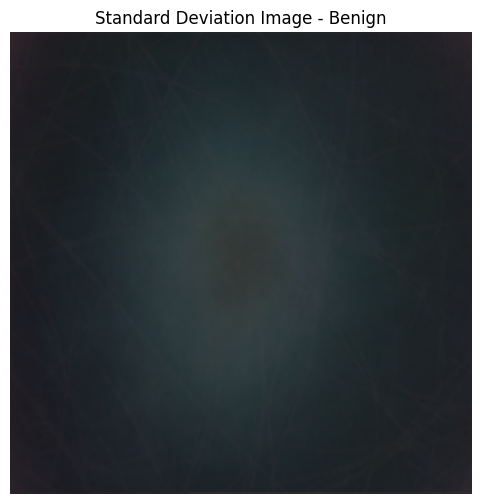

Standard Deviation Image for class: Malignant


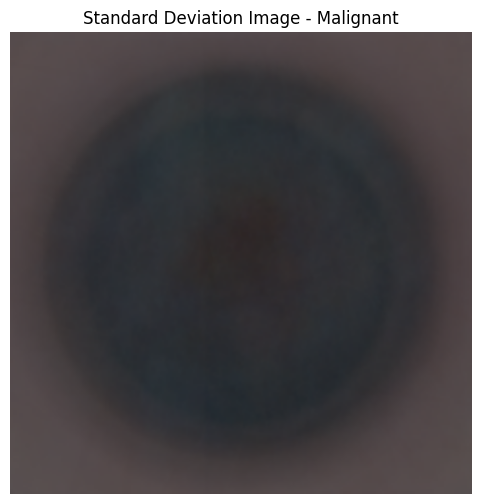

In [12]:
mean_images = {}
std_images = {}

for class_name, images in class_images.items():
    # Calculate the mean image by averaging along the first axis (images)
    mean_images[class_name] = np.mean(images, axis=0)

    # Calculate the standard deviation image by computing std along the first axis (images)
    std_images[class_name] = np.std(images, axis=0)

print("Mean and standard deviation images computed successfully.")

# Display the mean image for each class
for class_name, mean_img in mean_images.items():
    print(f"Mean Image for class: {class_name}")
    plt.figure(figsize=(6, 6))
    plt.imshow(mean_img.astype(np.uint8)) # Cast to uint8 for displaying image
    plt.title(f"Mean Image - {class_name}")
    plt.axis('off')
    plt.show()

# Display the standard deviation image for each class
for class_name, std_img in std_images.items():
    print(f"Standard Deviation Image for class: {class_name}")
    plt.figure(figsize=(6, 6))
    # Scale std_img for better visualization, as values can be small
    plt.imshow(std_img.astype(np.uint8)) # Cast to uint8 for displaying image
    plt.title(f"Standard Deviation Image - {class_name}")
    plt.axis('off')
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The mean pixel intensity values across all channels are higher for the 'Benign' class (R: 199.94, G: 148.02, B: 144.86) compared to the 'Malignant' class (R: 158.34, G: 126.83, B: 122.98), suggesting benign images tend to be brighter overall.
*   The standard deviation of pixel intensities is notably higher for the 'Malignant' class (R: 65.95, G: 60.65, B: 63.10) than the 'Benign' class (R: 37.49, G: 45.41, B: 49.32). This indicates a greater variation in pixel values within the malignant images, potentially reflecting more diverse textures or colors.
*   Both classes exhibit the full range of pixel intensities, with minimum values of 0.0 and maximum values of 255.0 across all channels.
*   The mean images provide a visual representation of the average appearance of each class, showing a generally brighter and more uniform appearance for the 'Benign' class compared to the 'Malignant' class.
*   The standard deviation images highlight areas of higher variability within each class. The 'Malignant' standard deviation image appears to show more widespread variation across the image compared to the 'Benign' standard deviation image.


# Base Model

In [13]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(0.5), # Added dropout layer with a dropout rate of 0.5
    layers.Dense(units=1, activation='sigmoid') # Binary classification
])

# Compile the model with explicit Adam optimizer hyperparameters
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False
)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763712299.477873      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763712299.478491      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,281 (42.64 MB)

 Trainable params: 11,177,281 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
EPOCHS = 20

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6)

start_time = time.time()
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)
end_time = time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1763712310.769121     138 service.cc:148] XLA service 0x7d49f800f220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763712310.770445     138 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763712310.770468     138 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763712311.156742     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/297 ━━━━━━━━━━━━━━━━━━━━ 40:49 8s/step - accuracy: 0.5000 - loss: 0.6978

I0000 00:00:1763712316.726452     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 ━━━━━━━━━━━━━━━━━━━━ 187s 603ms/step - accuracy: 0.6386 - loss: 0.6135 - val_accuracy: 0.7749 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 118s 398ms/step - accuracy: 0.8168 - loss: 0.4212 - val_accuracy: 0.7876 - val_loss: 0.5254 - learning_rate: 0.0010
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 119s 399ms/step - accuracy: 0.8387 - loss: 0.3793 - val_accuracy: 0.7897 - val_loss: 0.4982 - learning_rate: 0.0010
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 118s 398ms/step - accuracy: 0.8416 - loss: 0.3652 - val_accuracy: 0.7369 - val_loss: 0.5153 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [16]:
training_time = end_time - start_time
print(f"Training time (Base model): {training_time:.2f} seconds")

Training time (Base model): 543.04 seconds


In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy with base model: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.7841 - loss: 0.4661
Test accuracy with base model: 0.7555000185966492


In [18]:
# Save the trained model
model.save('melanoma_cnn_model.keras')
print("Model saved successfully.")

Model saved successfully.


# Hyper Parameters Tuning

## Model Evaluation Function

In [19]:
def evaluate_model(filters1, filters2, dropout1, dropout2, learning_rate, activation, last_activation):
    model = models.Sequential([
        layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation=activation, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(units=128, activation=activation),
        layers.Dropout(dropout1),
        layers.Dense(units=64, activation=activation),
        layers.Dropout(dropout2),
        layers.Dense(units=1, activation=last_activation)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=4,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        verbose=0
    )

    val_acc = history.history['val_accuracy'][-1]
    return val_acc, model, history

## Search Space Initialization

In [20]:
search_space = {}
search_space['filters1'] = [32, 128, 256]
search_space['filters2'] = [32, 128, 256]
search_space['dropout1'] = [0.1, 0.3, 0.5, 0.7]
search_space['dropout2'] = [0.1, 0.3, 0.5, 0.7]
search_space['learning_rate'] = [0.0001, 0.001, 0.01, 0.1]
search_space['activation'] = ['relu', 'elu', 'gelu']
search_space['last_activation'] = ['sigmoid']

## Neighborhood Generation

In [26]:
def _immediate_neighbours(index, dimension, state):
    neighbours = []
    vals = search_space[dimension]
    new_state_base = list(state)  # Convert tuple to list for modification

    if index == 0:
        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[1]
        neighbours.append(tuple(neigh_state))

        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[2]
        neighbours.append(tuple(neigh_state))
    elif index == len(vals) - 1:
        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[-2]
        neighbours.append(tuple(neigh_state))

        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[-3]
        neighbours.append(tuple(neigh_state))
    else:
        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[index - 1]
        neighbours.append(tuple(neigh_state))

        neigh_state = new_state_base.copy()
        neigh_state[list(search_space.keys()).index(dimension)] = vals[index + 1]
        neighbours.append(tuple(neigh_state))

    return neighbours

def get_neighbours(state):
    neighbours = []
    state_dict = {k: state[i] for i, k in enumerate(search_space.keys())}

    for k in search_space.keys():
        if k in ['activation', 'last_activation']:
            continue
        index = search_space[k].index(state_dict[k])
        new_neighbours = _immediate_neighbours(index, k, state)
        neighbours.extend(new_neighbours)

    # Add a neighbor with random activation and last_activation
    new_state = list(state)
    new_state[5] = np.random.choice(search_space['activation'])
    new_state[6] = np.random.choice(search_space['last_activation'])
    neighbours.append(tuple(new_state))

    return neighbours

# Simulated Annealing

In [22]:
initial_filters1 = random.choice(search_space['filters1'])
initial_filters2 = random.choice(search_space['filters2'])
initial_dropout1 = random.choice(search_space['dropout1'])
initial_dropout2 = random.choice(search_space['dropout2'])
initial_learning_rate = random.choice(search_space['learning_rate'])
initial_activation = random.choice(search_space['activation'])
initial_last_activation = random.choice(search_space['last_activation'])

initial_state = (initial_filters1, initial_filters2, initial_dropout1, initial_dropout2,
                 initial_learning_rate, initial_activation, initial_last_activation)

In [23]:
current_acc, _, _ = evaluate_model(*initial_state)
current_state = initial_state

best_state = current_state
best_acc = current_acc

print(f"Initial state: {initial_state}")
print(f"Initial validation accuracy: {current_acc}")

2025-11-21 08:25:36.646899: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,111,111]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-21 08:25:36.881827: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.235141795s
Trying algorithm eng12{k11=0} for conv (f32[32,256,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,111,111]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_confi

Initial state: (256, 256, 0.3, 0.3, 0.001, 'relu', 'sigmoid')
Initial validation accuracy: 0.7609797120094299


In [24]:
T = 1.0  # Initial temperature
T_min = 0.001
alpha = 0.7  # Cooling rate
iterations_per_temp = 3  # Number of iterations per temperature level

In [27]:
start_time = time.time()
while T > T_min:
    print(f"\nCurrent temperature: {T:.6f}")
    print(f"Current best accuracy: {best_acc:.4f} with state {best_state}")

    for _ in range(iterations_per_temp):
        # Get a random neighbor
        neighbors = get_neighbours(current_state)
        neighbor = random.choice(neighbors)

        # Evaluate neighbor
        neigh_acc, _, _ = evaluate_model(*neighbor)
        print(f"Evaluated neighbor {neighbor} with accuracy {neigh_acc:.4f}")

        # Calculate delta
        delta_acc = neigh_acc - current_acc

        # Decide whether to accept
        if delta_acc > 0 or random.uniform(0, 1) < math.exp(delta_acc / T):
            current_state = neighbor
            current_acc = neigh_acc
            print(f"Accepted new state {current_state} with accuracy {current_acc:.4f}")

            # Update best if better
            if current_acc > best_acc:
                best_acc = current_acc
                best_state = current_state
                print(f"New best state found: {best_state} with accuracy {best_acc:.4f}")

    # Cool down
    T *= alpha

end_time = time.time()
print("\nSimulated Annealing completed.")
print(f"Optimized hyperparameters: {best_state}")
print(f"Best validation accuracy: {best_acc}")


Current temperature: 1.000000
Current best accuracy: 0.7610 with state (256, 256, 0.3, 0.3, 0.001, 'relu', 'sigmoid')
Evaluated neighbor (256, 256, 0.5, 0.3, 0.001, 'relu', 'sigmoid') with accuracy 0.6288
Accepted new state (256, 256, 0.5, 0.3, 0.001, 'relu', 'sigmoid') with accuracy 0.6288


2025-11-21 08:57:22.511792: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,111,111]{3,2,1,0}, f32[32,32,109,109]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-21 08:57:23.180527: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.66884906s
Trying algorithm eng0{} for conv (f32[32,256,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,111,111]{3,2,1,0}, f32[32,32,109,109]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone"

Evaluated neighbor (256, 32, 0.5, 0.3, 0.001, 'relu', 'sigmoid') with accuracy 0.7884
Accepted new state (256, 32, 0.5, 0.3, 0.001, 'relu', 'sigmoid') with accuracy 0.7884
New best state found: (256, 32, 0.5, 0.3, 0.001, 'relu', 'sigmoid') with accuracy 0.7884
Evaluated neighbor (256, 32, 0.5, 0.5, 0.001, 'relu', 'sigmoid') with accuracy 0.6436
Accepted new state (256, 32, 0.5, 0.5, 0.001, 'relu', 'sigmoid') with accuracy 0.6436

Current temperature: 0.700000
Current best accuracy: 0.7884 with state (256, 32, 0.5, 0.3, 0.001, 'relu', 'sigmoid')
Evaluated neighbor (256, 32, 0.5, 0.7, 0.001, 'relu', 'sigmoid') with accuracy 0.5287
Accepted new state (256, 32, 0.5, 0.7, 0.001, 'relu', 'sigmoid') with accuracy 0.5287
Evaluated neighbor (256, 32, 0.5, 0.5, 0.001, 'relu', 'sigmoid') with accuracy 0.6427
Accepted new state (256, 32, 0.5, 0.5, 0.001, 'relu', 'sigmoid') with accuracy 0.6427
Evaluated neighbor (256, 256, 0.5, 0.5, 0.001, 'relu', 'sigmoid') with accuracy 0.7707
Accepted new state

In [28]:
training_time = end_time - start_time
print(f"Training time (Simulated annealing): {training_time:.2f} seconds")

Training time (Simulated annealing): 29169.21 seconds


In [29]:
filters1, filters2, dropout1, dropout2, learning_rate, activation, last_activation = best_state

optimized_model = models.Sequential([
    layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation=activation, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units=128, activation=activation),
    layers.Dropout(dropout1),
    layers.Dense(units=64, activation=activation),
    layers.Dropout(dropout2),
    layers.Dense(units=1, activation=last_activation)
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False
)
optimized_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train with more epochs
history = optimized_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,  # More epochs for final training
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 136s 445ms/step - accuracy: 0.6683 - loss: 0.5957 - val_accuracy: 0.7226 - val_loss: 0.5240 - learning_rate: 1.0000e-04
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 121s 407ms/step - accuracy: 0.8230 - loss: 0.4085 - val_accuracy: 0.7910 - val_loss: 0.4748 - learning_rate: 1.0000e-04
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 120s 404ms/step - accuracy: 0.8391 - loss: 0.3694 - val_accuracy: 0.7973 - val_loss: 0.4679 - learning_rate: 1.0000e-04
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 121s 407ms/step - accuracy: 0.8580 - loss: 0.3329 - val_accuracy: 0.7969 - val_loss: 0.4549 - learning_rate: 1.0000e-04
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 124s 418ms/step - accuracy: 0.8600 - loss: 0.3347 - val_accuracy: 0.7965 - val_loss: 0.4742 - learning_rate: 1.0000e-04
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 117s 395ms/step - accuracy: 0.8587 - loss: 0.3310 - val_accuracy: 0.8019 - val_loss: 0.4489 - learning_rate: 1.0000e-04
Epoch 7/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 

In [30]:
# Evaluate on test set
test_loss, test_acc = optimized_model.evaluate(test_generator)
print(f"Test accuracy with optimized model: {test_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8932 - loss: 0.2437
Test accuracy with optimized model: 0.8895000219345093


In [31]:
# Save the model
optimized_model.save('SA_optimized_melanoma_model.keras')
print("Optimized model saved as 'SA_optimized_melanoma_model.keras'")

Optimized model saved as 'SA_optimized_melanoma_model.keras'


# Tabu Search

In [ ]:
def random_solution():
    return {param: random.choice(values) for param, values in search_space.items()}

In [ ]:
MAX_ITER = 2

In [ ]:
def tabu_search(max_iter=MAX_ITER, tabu_tenure=8):
    current = random_solution()
    current_score, current_model, current_history = evaluate_model(**current)

    best = current.copy()
    best_score = current_score
    best_model = current_model
    best_history = current_history

    tabu_list = {}
    history_log = []

    print("===== TABU SEARCH STARTED =====")
    print(f"Initial solution: {current}")
    print(f"Initial validation accuracy: {current_score:.4f}")
    print(f"Tabu tenure: {tabu_tenure}, Max iterations: {max_iter}")
    print("=" * 60)

    # === Main Loop ===
    for i in range(max_iter):
        print(f"--- Iteration {i+1}/{max_iter} ---")
        print(f"Current parameters: {current}")
        print(f"Current accuracy: {current_score:.4f}")
        print(f"Current tabu list size: {len(tabu_list)}")

        neighbours = get_neighbours(current)
        print(f"Generated {len(neighbours)} neighbours to explore.")

        neighbor_scores = []
        skipped_due_to_tabu = 0
        used_aspiration = 0

        # === Evaluate each neighbour ===
        for n_idx, n in enumerate(neighbours):
            n_key = tuple(sorted(n.items()))
            print(f"  -> Evaluating neighbour {n_idx + 1}/{len(neighbours)}: {n}")

            if n_key in tabu_list and tabu_list[n_key] > 0:
                print(f"     - In tabu list (remaining tenure {tabu_list[n_key]}). Checking aspiration rule...")
                val_acc, _, _ = evaluate_model(**n)
                if val_acc > best_score:
                    print(f"     - Aspiration rule triggered. Accuracy {val_acc:.4f} > best {best_score:.4f}")
                    used_aspiration += 1
                    neighbor_scores.append((n, val_acc))
                else:
                    skipped_due_to_tabu += 1
                    print(f"     - Skipped (tabu and not improving best).")
            else:
                val_acc, _, _ = evaluate_model(**n)
                print(f"     - Accuracy: {val_acc:.4f}")
                neighbor_scores.append((n, val_acc))

        if not neighbor_scores:
            print(f"No admissible neighbours available. Stopping search.")
            break

        # Select best neighbour
        candidate, candidate_score = max(neighbor_scores, key=lambda x: x[1])
        print(f"Best neighbour selected with accuracy {candidate_score:.4f}")
        print(f"Neighbour parameters: {candidate}")

        #Update tabu list
        print("Updating tabu list:")
        expired = [k for k, v in tabu_list.items() if v <= 1]
        for k in expired:
            print(f"  - Expired: {dict(k)} removed from tabu list.")
            del tabu_list[k]

        for k in list(tabu_list.keys()):
            tabu_list[k] -= 1
            print(f"  - Decreased tenure for {dict(k)} to {tabu_list[k]}")

        tabu_list[tuple(sorted(current.items()))] = tabu_tenure
        print(f"  - Added current state to tabu list with tenure {tabu_tenure}")

        # Move to candidate
        current = candidate
        current_score = candidate_score
        current_model = None

        # Update best
        if current_score > best_score:
            print(f"New best found: {current_score:.4f} (previous best {best_score:.4f})")
            best = current.copy()
            best_score = current_score
        else:
            print(f"No improvement this iteration. Best remains {best_score:.4f}")

        # Summary of iteration
        print(f"Iteration summary:")
        print(f"  Skipped due to tabu: {skipped_due_to_tabu}")
        print(f"  Aspiration used: {used_aspiration}")
        print(f"  Current accuracy: {current_score:.4f}")
        print(f"  Best accuracy so far: {best_score:.4f}")
        print(f"  Tabu list size: {len(tabu_list)}")
        print("-" * 60)

        history_log.append((i+1, current_score, best_score, current.copy()))

    print("===== TABU SEARCH COMPLETED =====")
    print(f"Best hyperparameters found after {max_iter} iterations:")
    print(best)
    print(f"Best validation accuracy: {best_score:.4f}")
    print("=" * 60)

    return best, best_score, best_model, best_history

In [ ]:
best_params, best_acc, best_model, best_history = tabu_search()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761979487.888057      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761979487.888764      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can i

===== TABU SEARCH STARTED =====
Initial solution: {'filters1': 64, 'filters2': 256, 'dropout1': 0.1, 'dropout2': 0.7, 'learning_rate': 1e-05, 'activation': 'leaky_relu', 'last_activation': 'sigmoid'}
Initial validation accuracy: 0.7538
Tabu tenure: 8, Max iterations: 2

--- Iteration 1/2 ---
Current parameters: {'filters1': 64, 'filters2': 256, 'dropout1': 0.1, 'dropout2': 0.7, 'learning_rate': 1e-05, 'activation': 'leaky_relu', 'last_activation': 'sigmoid'}
Current accuracy: 0.7538
Current tabu list size: 0
Generated 11 neighbours to explore.
  -> Evaluating neighbour 1/11: {'filters1': 32, 'filters2': 256, 'dropout1': 0.1, 'dropout2': 0.7, 'learning_rate': 1e-05, 'activation': 'leaky_relu', 'last_activation': 'sigmoid'}
     - Accuracy: 0.7631
  -> Evaluating neighbour 2/11: {'filters1': 128, 'filters2': 256, 'dropout1': 0.1, 'dropout2': 0.7, 'learning_rate': 1e-05, 'activation': 'leaky_relu', 'last_activation': 'sigmoid'}
     - Accuracy: 0.7458
  -> Evaluating neighbour 3/11: {'fil

# Ant Colony Optimization

In [ ]:
params = list(search_space.keys())
num_params = len(params)

# Pheromones initialization
pheromones = {param: np.ones(len(search_space[param])) for param in params}

# ACO parameters
num_ants = 5
num_iterations = 5
evaporation_rate = 0.5

best_state = None
best_acc = 0.0

all_solutions = []

for iteration in range(num_iterations):
    print(f"\nIteration {iteration + 1}/{num_iterations}")
    iteration_solutions = []
    for ant in range(num_ants):
        state_list = []
        for param in params:
            probs = pheromones[param] / np.sum(pheromones[param])
            choice_idx = np.random.choice(len(probs), p=probs)
            value = search_space[param][choice_idx]
            state_list.append(value)
        state = tuple(state_list)
        acc, _, _ = evaluate_model(*state)
        iteration_solutions.append((state, acc))
        all_solutions.append((state, acc))
        print(f"Ant {ant + 1}: State {state} with accuracy {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_state = state
            print(f"New best state found: {best_state} with accuracy {best_acc:.4f}")
    # Update pheromones
    for param in params:
        pheromones[param] *= (1 - evaporation_rate)
    for state, acc in iteration_solutions:
        for i, value in enumerate(state):
            param = params[i]
            idx = search_space[param].index(value)
            pheromones[param][idx] += acc

print("\nAnt Colony Optimization completed.")
print(f"Optimized hyperparameters: {best_state}")
print(f"Best validation accuracy: {best_acc}")


Iteration 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Ant 1: State (32, 256, 0.6, 0.5, 1e-05, 'relu', 'sigmoid') with accuracy 0.7437
New best state found: (32, 256, 0.6, 0.5, 1e-05, 'relu', 'sigmoid') with accuracy 0.7437
Ant 2: State (256, 64, 0.7, 0.2, 1e-05, 'gelu', 'sigmoid') with accuracy 0.7310
Ant 3: State (128, 64, 0.5, 0.3, 1e-05, 'leaky_relu', 'sigmoid') with accuracy 0.7276
Ant 4: State (256, 64, 0.3, 0.1, 0.01, 'elu', 'sigmoid') with accuracy 0.5287
Ant 5: State (128, 32, 0.7, 0.4, 0.1, 'elu', 'sigmoid') with accuracy 0.4713

Iteration 2/5
Ant 1: State (128, 64, 0.4, 0.1, 0.0001, 'relu', 'sigmoid') with accuracy 0.7956
New best state found: (128, 64, 0.4, 0.1, 0.0001, 'relu', 'sigmoid') with accuracy 0.7956
Ant 2: State (32, 64, 0.6, 0.3, 1e-05, 'relu', 'sigmoid') with accuracy 0.7572
Ant 3: State (128, 16, 0.2, 0.3, 0.01, 'elu', 'sigmoid') with accuracy 0.5291
Ant 4: State (16, 32, 0.6, 0.1, 1e-05, 'relu', 'sigmoid') with accuracy 0.7470
Ant 5: State (256, 32, 0.5, 0.6, 0.1, 'relu', 'sigmoid') with accuracy 0.5300

Iteration

In [ ]:
filters1, filters2, dropout1, dropout2, learning_rate, activation, last_activation = best_state

optimized_model = models.Sequential([
    layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation=activation, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation=activation),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units=128, activation=activation),
    layers.Dropout(dropout1),
    layers.Dense(units=64, activation=activation),
    layers.Dropout(dropout2),
    layers.Dense(units=1, activation=last_activation)
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    amsgrad=False
)
optimized_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train with more epochs
history = optimized_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,  # More epochs for final training
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test set
test_loss, test_acc = optimized_model.evaluate(test_generator)
print(f"Test accuracy with optimized model: {test_acc}")

# Save the model
optimized_model.save('optimized_melanoma_model.keras')
print("Optimized model saved as 'optimized_melanoma_model.keras'")

Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 66s 206ms/step - accuracy: 0.7029 - loss: 0.5487 - val_accuracy: 0.7462 - val_loss: 0.4974 - learning_rate: 1.0000e-04
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 198ms/step - accuracy: 0.8202 - loss: 0.3946 - val_accuracy: 0.7568 - val_loss: 0.5398 - learning_rate: 1.0000e-04
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 198ms/step - accuracy: 0.8321 - loss: 0.3783 - val_accuracy: 0.7736 - val_loss: 0.5047 - learning_rate: 1.0000e-04
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - accuracy: 0.8405 - loss: 0.3580 - val_accuracy: 0.7855 - val_loss: 0.4616 - learning_rate: 1.0000e-04
Epoch 5/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 59s 197ms/step - accuracy: 0.8532 - loss: 0.3301 - val_accuracy: 0.7715 - val_loss: 0.4787 - learning_rate: 1.0000e-04
Epoch 6/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 212ms/step - accuracy: 0.8471 - loss: 0.3574 - val_accuracy: 0.7846 - val_loss: 0.4440 - learning_rate: 1.0000e-04
Epoch 7/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 78s 20

Test accuracy with optimized model: 0.8579999804496765
Optimized model saved as 'optimized_melanoma_model.keras'


# Particle Swarm Optimization

In [ ]:
N_PARTICLES=4
N_ITER=3
W=0.7
C1=1.5
C2=1.5

In [ ]:
class Particle:
    def __init__(self, search_space):
        self.position = {
            'filters1': random.choice(search_space['filters1']),
            'filters2': random.choice(search_space['filters2']),
            'dropout1': random.choice(search_space['dropout1']),
            'dropout2': random.choice(search_space['dropout2']),
            'learning_rate': random.choice(search_space['learning_rate']),
            'activation': random.choice(search_space['activation']),
            'last_activation': random.choice(search_space['last_activation'])
        }

        self.velocity = {key: 0 for key in self.position.keys()}
        self.best_position = self.position.copy()
        self.best_score = -np.inf
        self.best_model = None
        self.best_history = None

In [ ]:
def pso_optimize(n_particles=N_PARTICLES, n_iter=N_ITER, w=W, c1=C1, c2=C2):
    swarm = [Particle(search_space) for _ in range(n_particles)]
    gbest_position = swarm[0].position.copy()
    gbest_score = -np.inf
    gbest_model = None
    gbest_history = None

    print("===== PARTICLE SWARM OPTIMIZATION STARTED =====")
    print(f"Particles: {n_particles}, Iterations: {n_iter}")
    print("=" * 60)

    for iteration in range(n_iter):
        print(f"=== Iteration {iteration + 1}/{n_iter} ===")

        for i, p in enumerate(swarm):
            val_acc, model, history = evaluate_model(**p.position)
            print(f"Particle {i+1}: {p.position}, Accuracy={val_acc:.4f}")

            if val_acc > p.best_score:
                p.best_score = val_acc
                p.best_position = p.position.copy()
                p.best_model = model
                p.best_history = history

            if val_acc > gbest_score:
                gbest_score = val_acc
                gbest_position = p.position.copy()
                gbest_model = model
                gbest_history = history

        for p in swarm:
            for param in search_space.keys():
                if param in ['activation', 'last_activation']:
                    # Random categorical update with some probability
                    if random.random() < 0.3:
                        p.position[param] = random.choice(search_space[param])
                else:
                    r1, r2 = random.random(), random.random()
                    options = search_space[param]
                    current_idx = options.index(p.position[param])
                    pbest_idx = options.index(p.best_position[param])
                    gbest_idx = options.index(gbest_position[param])

                    velocity = (
                        w * p.velocity[param]
                        + c1 * r1 * (pbest_idx - current_idx)
                        + c2 * r2 * (gbest_idx - current_idx)
                    )
                    p.velocity[param] = velocity

                    new_idx = int(round(current_idx + velocity))
                    new_idx = max(0, min(new_idx, len(options) - 1))
                    p.position[param] = options[new_idx]

        print(f"Global Best Accuracy so far: {gbest_score:.4f}")
        print(f"Global Best Params: {gbest_position}")
        print("-" * 60)

    print("===== PSO COMPLETED =====")
    print(f"Best Hyperparameters Found:")
    print(gbest_position)
    print(f"Best Validation Accuracy: {gbest_score:.4f}")
    print("=" * 60)

    return gbest_position, gbest_score, gbest_model, gbest_history

In [ ]:
pso_best_params, pso_best_acc, pso_best_model, pso_best_history = pso_optimize()


===== PARTICLE SWARM OPTIMIZATION STARTED =====
Particles: 4, Iterations: 3

=== Iteration 1/3 ===
Particle 1: {'filters1': 16, 'filters2': 16, 'dropout1': 0.7, 'dropout2': 0.3, 'learning_rate': 0.0001, 'activation': 'elu', 'last_activation': 'sigmoid'}, Accuracy=0.7931
Particle 2: {'filters1': 256, 'filters2': 32, 'dropout1': 0.1, 'dropout2': 0.7, 'learning_rate': 0.0001, 'activation': 'leaky_relu', 'last_activation': 'sigmoid'}, Accuracy=0.7863
Particle 3: {'filters1': 256, 'filters2': 64, 'dropout1': 0.4, 'dropout2': 0.3, 'learning_rate': 1e-05, 'activation': 'leaky_relu', 'last_activation': 'sigmoid'}, Accuracy=0.7728
Particle 4: {'filters1': 32, 'filters2': 256, 'dropout1': 0.6, 'dropout2': 0.7, 'learning_rate': 0.1, 'activation': 'relu', 'last_activation': 'sigmoid'}, Accuracy=0.5279
Global Best Accuracy so far: 0.7931
Global Best Params: {'filters1': 16, 'filters2': 16, 'dropout1': 0.7, 'dropout2': 0.3, 'learning_rate': 0.0001, 'activation': 'elu', 'last_activation': 'sigmoid'}